# Petitie Aprilbeweging 1853

Van prof. dr. Fred van Lieburg een digitale versie verkegen van een petitie tegen de het herstel van de bisschoppelijke hiërarchie in Nederland door paus Pius IX. Deze petitie is was een protest vanui protestantse en conservatieve hoek en staat ook wel bekend als de *Aprilbeweging* https://nl.wikipedia.org/wiki/Aprilbeweging. De beweging richtte zich tevens tegen het kabinet-Thorbecke I, dat de Rooms-Katholieke Kerk geen strobreed in de weg legde, op grond van de scheiding van kerk en staat en de vrijheid van godsdienst.

In de getranscribeerde petitie, geleverd als excelsheet, staan plaatsnamen en provincies. Om een choropleth kaart te kunnen produceren met daarop de ruimtelijk verspreiding van de aantallen die deze petitie hebben ondertekend dienen de plaatsnamen gekoppeld te worden aan historische gemeentegrenzen. 

Voor de historische gemeentegrenzen is gebruik gemaakt van;
Zijdeman, Richard; Mac Gillavry, Edward, 2020, "nlgis-boundary-files with Amsterdam Code", https://hdl.handle.net/10622/URI8O2, IISH Data Collection, V1 
en zijn de gemeentegrenzen van 1853 geselecteerd.

De petitie telt 933 gemeentes / plaatnamen

De gemeentes uit 1853 zijn er in totaal 1209.


Het matchen van de gemeentegrenzen met de petitie vergde een aantal stappen. 

**Stap 1:** Een join op basis van de plaatsnamen in het excelsheet en het 1853 gemeentegrenzen bestand.
*Dit leverde 427 matches op.*

**Stap 2.1:** 
Dit betekent dat er nog 933-427=506 plaatsnamen nog niet gematcht konden worden met de oude gemeentegrenzen. Een van de oorzaken hiervan is dat - ook toen - gemeentes uit meerdere plaatsen konden bestaan. 
Bijvoorbeeld; het plaatsje Holysloot maakte, wanneer uit wordt gegaan van de 1853 gemeentegrenzen, onderdeel uit van de gemeente Ransdorp. In de tweede stap worden dan ook de overbleven plaatsnamen gegeocodeerd op basis van de locatieserver van pdok en wikipedia. Hierbij is de aanname dat de plaatsnamen door de tijd niet zijn veranderd. 

**Stap 2.2:** 
Om vervolgens de plaatsnamen aan de gemeentegrenzen te koppelen is een spatial join uitgevoerd en zijn de aantallen, wanneer deze toebehoren aan eenzelfde 1853 gemeente bij elkaar opgeteld.

**Stap 3:**
Na al deze stappen bleven er nog 28 plaatsnamen over die wel op de petitie staan, maar niet in het gemeentegrenzen of konden worden gegeocodeerd op basis van huidige plaatsnamen. Deze zijn handmatig nagelopen.

In [1]:
# In deze stap worden de benodigde libraries geïmporteerd en functies gedefinieerd om plaatsnamen te geocoderen voor stap 2
import time
import requests
import pandas as pd
import geopandas as gpd


# Panda settings for showing data (this is foremost done to more easily explore the data while processing it)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)



PDOK_URL = "https://api.pdok.nl/bzk/locatieserver/search/v3_1/free"

ALLOWED_TYPES = {"woonplaats", "gemeente"}  # looser: also municipalities

def geocode_pdok_placeonly(query: str, rows: int = 5, timeout: int = 20):
    params = {"q": query, "rows": rows}
    r = requests.get(PDOK_URL, params=params, timeout=timeout)
    r.raise_for_status()
    docs = r.json().get("response", {}).get("docs", [])

    # filter to allowed types
    candidates = [d for d in docs if d.get("type") in ALLOWED_TYPES]
    if not candidates:
        return None, None, None, None, None

    # pick best scoring allowed candidate
    best = max(candidates, key=lambda d: d.get("score", 0))

    label = best.get("weergavenaam")
    score = best.get("score")
    typ = best.get("type")

    centroide_ll = best.get("centroide_ll")  # "POINT(lon lat)"
    if not centroide_ll:
        return None, None, label, score, typ

    inside = centroide_ll.replace("POINT(", "").replace(")", "")
    lon_str, lat_str = inside.split()
    lon, lat = float(lon_str), float(lat_str)

    return lat, lon, label, score, typ


def geocode_list_pdok_placeonly(names, sleep_s: float = 0.05):
    out = []
    for n in names:
        lat, lon, label, score, typ = geocode_pdok_placeonly(n)
        out.append({"query": n, "match_label": label, "type": typ, "lat": lat, "lon": lon, "score": score})
        time.sleep(sleep_s)
    return pd.DataFrame(out)

In [2]:
folder_path = "E://Dropbox//ONDERNEMEN_MAURICE//opdracht9_Lieburg_atlas//1853_map//"

In [3]:
# import the gemeentegrenzen uit 1853. 
gem_1853 = gpd.read_file(folder_path+"nl_1853.geojson")

# projecteer gem_1853 naar RD_new 28992
gem_1853 = gem_1853.to_crs(epsg=28992)

In [ ]:
##############
# STAP1
##############

# Omdat sommige plaatsnamen in meerdere provincies voorkomen zullen we voor stap 1 een join uitvoeren op basis van de combinatie plaatsnaam provincie. Echter bevat het bestand nl_1853.geojson geen provincie id. 
# Omdat de provinciegrenzen door de tijd heen ook zijn veranderd is uitgegaan van de oudst vindbare provincie grenzen waarbij zowel de gemeentegrenzen en provinciegrenzen te vinden zijn. 
# De dataset die hiervoor gevonden is afkomstig van; https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/cbs-gebiedsindelingen . Er is gekozen voor 1995 (de oudste)
prov_1995 = gpd.read_file( folder_path+"cbsgebiedsindelingen1995_2015//cbsgebiedsindelingen1995.gpkg"  , layer="provincie_gegeneraliseerd")

In [5]:
# omdat de geometrien van prov_1995 en gem_1853 niet exact overeen komen. Er is sprake van klein slivers in het digitaliseerproces lukt gem_1853_provincie = gpd.sjoin(gem_1853, prov_1995, how="inner", predicate="within") helaas niet.
# Daarom wordt het gedaan op basis van een intersect en de grootste overlap.
 
# 1): all pairs that intersect
intersect_st1 = gpd.sjoin(
    gem_1853.reset_index(names="left_id"),
    prov_1995.reset_index(names="right_id"),
    how="left",
    predicate="intersects"
)

In [6]:
# 2) Compute intersection area for each candidate pair
# (merge geometries back in so we can intersect them)
intersect_st2 = intersect_st1.merge(
    prov_1995.reset_index(names="right_id")[["right_id", "geometry"]],
    on="right_id",
    suffixes=("_left", "_right"),
)

In [7]:
intersect_st2 = intersect_st2.set_geometry("geometry_left")

intersect_st2["overlap_area"] = (
    intersect_st2.geometry
        .intersection(intersect_st2["geometry_right"])
        .area
)

In [8]:
# 3) Keep the single best match per left polygon (largest overlap)
best = (
    intersect_st2.sort_values(["left_id", "overlap_area"], ascending=[True, False])
        .drop_duplicates("left_id")
)

# 4) Build final output: left polygons + selected right attributes
# Drop right geometry if you only want left geometry in the result
result = (
    gem_1853.reset_index(names="left_id")
        .merge(
            best.drop(columns=["geometry_right"], errors="ignore"),
            on="left_id",
            how="left",
            suffixes=("", "_rightattrs"),
        )
)

In [9]:
result.shape

(1209, 19)

In [10]:
result["statnaam"].value_counts().sort_index()

Drenthe           33
Flevoland          2
Friesland         45
Gelderland       120
Groningen         57
Limburg          125
Noord-Brabant    185
Noord-Holland    141
Overijssel        61
Utrecht           97
Zeeland          116
Zuid-Holland     227
Name: statnaam, dtype: int64

In [11]:
flevoland = result[result["statnaam"] == "Flevoland"]

In [13]:
# De plaatsen Schokland en Urk in de 1853 dataset zijn aan de nog niet bestaande provincie Flevoland toegekend... Deze is handmatig aangepast naar Overijssel (schokland) en Noord-Holland (Urk) (deze toekenning is gehaald uit het petitiebestand). (Idealiter hebben we een provinciegrenzen bestand. Of een CBS code icm provincie bestand.) 
result.loc[result["naam"].str.contains("Urk", na=False),"statnaam"] = "Noord-Holland"
result.loc[result["naam"].str.contains("Schokland", na=False),"statnaam"] = "Overijssel"

In [14]:
gem_1853_provincie = result[["naam", "cbscode", "geometry", "statnaam"]].rename(
    columns={"naam": "gemeente", "statnaam": "provincie"}
)

In [16]:
# het tabblad conversie is het te koppelen bestand en is gemaakt op basis van blad 1 uit het bestand.
pet_1853 = pd.read_excel(folder_path+"Woonplaatsenlijst_adres_1853.xlsx", sheet_name="conversie")

In [17]:
# id toegevoegd aan de petitie om dubbele matches er later uit te halen (gevallen als Bergen NH vs Bergen L etc. )
pet_1853['id'] = range(1, len(pet_1853) + 1)
pet_1853['id']= pet_1853['id'].astype(int)

In [18]:
pet_1853.head()

,Woonplaats,aantal name,Provincie,id
0,Adorp,48,Groningen,1
1,Aduard,60,Groningen,2
2,"Andel, den",66,Groningen,3
3,"Apel, Ter",36,Groningen,4
4,Appingedam,84,Groningen,5


In [19]:
# inner join voor alle gevallen die volledig matchen voor plaatsnaam en provincie
gem_1853_petitie_true = gem_1853_provincie.merge(
    pet_1853,
    left_on=["gemeente", "provincie"],
    right_on=["Woonplaats", "Provincie"],
    how="inner"
)

In [20]:
gem_1853_petitie_true.shape

(427, 8)

In [ ]:
##############
# STAP 2.1
##############

petitie_not_gem_1853 = gem_1853_provincie.merge(
    pet_1853,
    left_on=["gemeente", "provincie"],
    right_on=["Woonplaats", "Provincie"],
    how="right"
)

In [22]:
petitie_not_gem_1853_sub = petitie_not_gem_1853[petitie_not_gem_1853['gemeente'].isnull()]

In [23]:
petitie_not_gem_1853_sub.head()

,gemeente,cbscode,geometry,provincie,Woonplaats,aantal name,Provincie,id
2,NaN,NaN,None,NaN,"Andel, den",66,Groningen,3
3,NaN,NaN,None,NaN,"Apel, Ter",36,Groningen,4
9,NaN,NaN,None,NaN,"Boer, Ten",52,Groningen,10
12,NaN,NaN,None,NaN,Eenum,21,Groningen,13
13,NaN,NaN,None,NaN,Eexta,64,Groningen,14


In [24]:
petitie_not_gem_1853_sub = petitie_not_gem_1853_sub.drop(columns=["gemeente", "cbscode", "geometry", "provincie"])

In [25]:
petitie_not_gem_1853_sub.shape

(506, 4)

In [26]:
geocode = petitie_not_gem_1853_sub.join(geocode_list_pdok_placeonly(petitie_not_gem_1853_sub["Woonplaats"].tolist()).set_index("query"), on="Woonplaats")

In [27]:
geocode.shape

(516, 9)

In [28]:
geocode = geocode.drop_duplicates()

In [29]:
geocode

,Woonplaats,aantal name,Provincie,id,match_label,type,lat,lon,score
2,"Andel, den",66,Groningen,3,"Den Andel, Het Hogeland, Groningen",woonplaats,53.403824,6.518971,13.548037
3,"Apel, Ter",36,Groningen,4,"Ter Apel, Westerwolde, Groningen",woonplaats,52.882894,7.078466,15.677116
9,"Boer, Ten",52,Groningen,10,"Ten Boer, Groningen, Groningen",woonplaats,53.273014,6.694938,16.729320
12,Eenum,21,Groningen,13,"Eenum, Eemsdelta, Groningen",woonplaats,53.336641,6.783525,14.299488
13,Eexta,64,Groningen,14,None,None,NaN,NaN,NaN
14,Enumatil,50,Groningen,15,"Enumatil, Westerkwartier, Groningen",woonplaats,53.214580,6.410933,13.813419
16,Farnsum,53,Groningen,17,None,None,NaN,NaN,NaN
17,Garrelsweer,9,Groningen,18,"Garrelsweer, Eemsdelta, Groningen",woonplaats,53.305256,6.770773,13.320892
18,Garsthuizen,28,Groningen,19,"Garsthuizen, Eemsdelta, Groningen",woonplaats,53.372130,6.730324,14.000185
20,Grootegast en Oldekerk,31,Groningen,21,"Oldekerk, Westerkwartier, Groningen",woonplaats,53.229144,6.331670,12.829239


In [30]:
# omdat er toch wat mismatches tussen zitten is heeft een manuele curatie plaatsgevonden
# Hierbij is ervan uitgegaan dat wanneer de provinicie en op zijn minst een van de plaatsnamen overeen kwam dat het correct zou zijn. 
# Deze manuele curatie heeft plaatsgevonden in excel door een x toe te voegen bij alle velden die kloppen (disclaimer, hier kunnen fouten tussen zitten). 

geocode.to_excel("geocode.xlsx", index=False)


In [ ]:
geocode_checked = pd.read_excel("geocode_checked.xlsx")
# filter op gecorriceerde items
geocode_correct = geocode_checked[geocode_checked["correct"] == "x"]
not_geocoded = geocode_checked[geocode_checked["correct"] != "x"]
not_geocoded = not_geocoded.drop(columns=["match_label", "type", "lat", "lon", "score", "opmerkingen", "correct"])

In [36]:
# Geocoder toegepast op basis van wikipedia links 
not_geocoded['plaats_prov'] = not_geocoded["Woonplaats"].astype(str) + ", " + not_geocoded["Provincie"].astype(str)

In [37]:
not_geocoded.head()

,Woonplaats,Provincie,aantal name,id,plaats_prov
4,Eexta,Groningen,64,14,"Eexta, Groningen"
6,Farnsum,Groningen,53,17,"Farnsum, Groningen"
14,Leeg- en Hoogkerk,Groningen,36,29,"Leeg- en Hoogkerk, Groningen"
15,"Marne, de",Groningen,10,32,"Marne, de, Groningen"
19,Middelbert en Engelbert,Groningen,98,39,"Middelbert en Engelbert, Groningen"


In [38]:
plaats_prov_list = not_geocoded["plaats_prov"].tolist()

In [40]:
import re
import time
import requests
import pandas as pd

# ---------------- HELPERS ----------------
def parse_plaats_prov(s: str) -> tuple[str, str]:
    s = " ".join(s.split())
    if "," not in s:
        return s.strip(), ""
    place_part, prov_part = s.rsplit(",", 1)
    return place_part.strip(" ,"), prov_part.strip(" ,")

def split_components(place_part: str) -> list[str]:
    """
    Split combined place strings into components for Option A centroid.
    Handles:
      - A&B
      - X en Y
      - A,B,C (when used as multiple places)
    """
    s = place_part.strip()
    s = s.replace(";", ",")
    s = re.sub(r"\s*&\s*", "&", s)
    s = re.sub(r"\s+en\s+", " en ", s, flags=re.IGNORECASE)

    parts = []
    for chunk in s.split("&"):
        chunk = chunk.strip()
        if re.search(r"\ben\b", chunk, flags=re.IGNORECASE):
            parts.extend([x.strip(" ,") for x in re.split(r"\s+en\s+", chunk, flags=re.IGNORECASE) if x.strip(" ,")])
        else:
            parts.append(chunk)

    final = []
    for p in parts:
        if "," in p:
            final.extend([x.strip() for x in p.split(",") if x.strip()])
        else:
            final.append(p.strip())

    # dedupe preserving order
    seen = set()
    out = []
    for x in final:
        k = x.lower()
        if k not in seen:
            out.append(x)
            seen.add(k)
    return out

# ---------------- WIKIPEDIA LOOKUP ----------------
SESSION = requests.Session()
HEADERS = {"User-Agent": "plaats_prov_wikipedia_coords/1.0 (contact: you@example.com)"}

def wiki_api_get_coords(title: str, lang: str = "nl"):
    """
    Return (lat, lon, page_title, pageid, fullurl) or None if not found.
    Uses MediaWiki API: prop=coordinates and follows redirects.
    """
    url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "coordinates|info",
        "inprop": "url",
        "titles": title,
        "redirects": 1,
        "converttitles": 1,
        "coprimary": "primary",
        "colimit": 1,
    }
    r = SESSION.get(url, params=params, headers=HEADERS, timeout=30)
    r.raise_for_status()
    data = r.json()

    pages = data.get("query", {}).get("pages", {})
    if not pages:
        return None

    page = next(iter(pages.values()))
    if "missing" in page:
        return None

    coords = page.get("coordinates")
    if not coords:
        return None

    c0 = coords[0]
    lat, lon = c0.get("lat"), c0.get("lon")
    if lat is None or lon is None:
        return None

    return float(lat), float(lon), page.get("title"), page.get("pageid"), page.get("fullurl")

def wiki_search_first(query: str, lang: str = "nl"):
    """
    If exact title lookup fails, search and return best-matching page title.
    """
    url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "list": "search",
        "srsearch": query,
        "srlimit": 1,
    }
    r = SESSION.get(url, params=params, headers=HEADERS, timeout=30)
    r.raise_for_status()
    data = r.json()
    hits = data.get("query", {}).get("search", [])
    if not hits:
        return None
    return hits[0].get("title")

def get_coords_from_wikipedia(place: str, province: str):
    """
    Try to get coordinates for a place, using:
      1) exact title on nlwiki
      2) search on nlwiki
      3) exact title on enwiki
      4) search on enwiki
    We try queries with and without province to improve findability.
    """
    candidates = [
        f"{place} ({province})" if province else None,
        f"{place}, {province}" if province else None,
        f"{place} {province}" if province else None,
        place,
    ]
    candidates = [c for c in candidates if c]

    # 1) exact nl
    for q in candidates:
        res = wiki_api_get_coords(q, "nl")
        if res:
            return ("nl", q, *res)

    # 2) search nl
    for q in candidates:
        found_title = wiki_search_first(q, "nl")
        if found_title:
            res = wiki_api_get_coords(found_title, "nl")
            if res:
                return ("nl(search)", q, *res)

    # 3) exact en
    for q in candidates:
        res = wiki_api_get_coords(q, "en")
        if res:
            return ("en", q, *res)

    # 4) search en
    for q in candidates:
        found_title = wiki_search_first(q, "en")
        if found_title:
            res = wiki_api_get_coords(found_title, "en")
            if res:
                return ("en(search)", q, *res)

    return None

# ---------------- PROCESS LIST ----------------
rows = []
for original in plaats_prov_list:
    place_part, province = parse_plaats_prov(original)
    components = split_components(place_part)

    hits = []
    notes = []

    for comp in components:
        try:
            found = get_coords_from_wikipedia(comp, province)
        except Exception as e:
            found = None
            notes.append(f"error:{comp}:{type(e).__name__}")

        if found:
            lang_used, query_used, lat, lon, page_title, pageid, fullurl = found
            hits.append({
                "component": comp,
                "lat": lat,
                "lon": lon,
                "wiki_lang": lang_used,
                "wiki_title": page_title,
                "wiki_url": fullurl,
                "query_used": query_used,
            })
        else:
            notes.append(f"not_found:{comp}")

        time.sleep(0.2)  # be polite to Wikipedia

    if hits:
        lat_centroid = sum(h["lat"] for h in hits) / len(hits)
        lon_centroid = sum(h["lon"] for h in hits) / len(hits)
        used = "; ".join(h["component"] for h in hits)
        urls = " | ".join(h["wiki_url"] for h in hits[:3]) + (" | ..." if len(hits) > 3 else "")
    else:
        lat_centroid, lon_centroid, used, urls = None, None, "", ""

    rows.append({
        "plaats_prov": original,
        "province": province,
        "components_used_for_centroid": used,
        "latitude": lat_centroid,
        "longitude": lon_centroid,
        "wikipedia_urls_sample": urls,
        "notes": "; ".join(notes)
    })

df = pd.DataFrame(rows)

# ---------------- EXPORT ----------------
out_path = "plaats_prov_geocoded_wikipedia.xlsx"
df.to_excel(out_path, index=False)
print(f"Saved: {out_path}")


Saved: plaats_prov_geocoded_wikipedia.xlsx


In [ ]:
#uitkomst van dit excelsheet zijn wederom manueel gecureerd aangezien er aan aantal fouten in zaten. 
geocode_checked_wiki = pd.read_excel("plaats_prov_geocoded_wikipedia.xlsx")
# filter op gecorriceerde items
geocode_correct_wiki = geocode_checked_wiki[geocode_checked_wiki["correct"] == "x"]
not_geocoded_wiki = geocode_checked_wiki[geocode_checked_wiki["correct"] != "x"]


In [43]:
not_geocoded_wiki = not_geocoded_wiki.drop(columns=["correct", "components_used_for_centroid", "latitude", "longitude", "wikipedia_urls_sample", "notes"])

In [46]:
not_geocoded_wiki.shape

(28, 2)

In [ ]:
# De laatste 28 zijn manueel gecureerd 
not_geocoded_wiki.to_excel("not_geocoded_wiki.xlsx", index=False)

In [48]:
manually_curated = pd.read_excel("not_geocoded_wiki.xlsx")

In [51]:
manually_curated.head()

,plaats_prov,province,link,lat lon,opmerkingen,lat,lon
0,"Marne, de, Groningen",Groningen,https://nl.wikipedia.org/wiki/De_Marne,"53.35, 6.366667",NaN,53.35,6.366667
1,"Bergumerheide, Friesland",Friesland,https://nl.wikipedia.org/wiki/Noordbergum,"53.223611, 6.003889",NaN,53.223611,6.003889
2,"Herbajum, Friesland",Friesland,https://nl.wikipedia.org/wiki/Herbaijum,"53.185278, 5.495",NaN,53.185278,5.495
3,"OldeNijeberkoop, Friesland",Friesland,https://nl.wikipedia.org/wiki/Nijeberkoop,"52.959167, 6.190556",NaN,52.959167,6.190556
4,"Beusichen, Gelderland",Gelderland,https://nl.wikipedia.org/wiki/Beusichem,"51.948889, 5.2925",NaN,51.948889,5.2925


In [50]:
manually_curated[["lat", "lon"]] = manually_curated["lat lon"].str.split(",", expand=True)

In [52]:
manually_curated.head()

,plaats_prov,province,link,lat lon,opmerkingen,lat,lon
0,"Marne, de, Groningen",Groningen,https://nl.wikipedia.org/wiki/De_Marne,"53.35, 6.366667",NaN,53.35,6.366667
1,"Bergumerheide, Friesland",Friesland,https://nl.wikipedia.org/wiki/Noordbergum,"53.223611, 6.003889",NaN,53.223611,6.003889
2,"Herbajum, Friesland",Friesland,https://nl.wikipedia.org/wiki/Herbaijum,"53.185278, 5.495",NaN,53.185278,5.495
3,"OldeNijeberkoop, Friesland",Friesland,https://nl.wikipedia.org/wiki/Nijeberkoop,"52.959167, 6.190556",NaN,52.959167,6.190556
4,"Beusichen, Gelderland",Gelderland,https://nl.wikipedia.org/wiki/Beusichem,"51.948889, 5.2925",NaN,51.948889,5.2925


In [ ]:
# Er zijn nu een aantal bestanden gegenereerd. 
# 1) een 1853 geopandas dataframe met geometriën van gemeentes; gem_1853_petitie_true
# 2) lon lat coordinaten gegenereerd op basis van pdok geocoder; geocode_correct
# 3) lon lat coordinaten op basis van wikipedia; geocode_correct_wiki
# 4) lon lat op basis van manuele curatie; manually_curated

# eerst moeten we voor manually_curated en geocode_correct_wiki weer de id-s en de aantallen joinen. Dat doen we op basis van een innerjoin met not_geocoded (dit kan zeker netter...)

manually_curated_id = pd.merge(
    manually_curated,
    not_geocoded,
    left_on="plaats_prov",
    right_on="plaats_prov",
    how="inner"
)

geocode_correct_wiki_id = pd.merge(
    geocode_correct_wiki,
    not_geocoded,
    left_on="plaats_prov",
    right_on="plaats_prov",
    how="inner"
)


In [ ]:
# vervolgens moeten de tabellen 2-3-4 worden geharmoniseerd om tot 1 tabel te komen
# checken of de aantallen nog kloppen

print(manually_curated_id.shape)
print(geocode_correct_wiki_id.shape)
print(geocode_correct.shape) 

In [69]:
manually_curated_id.head()


,lat,lon,Woonplaats,Provincie,aantal name,id
0,53.35,6.366667,"Marne, de",Groningen,10,32
1,53.223611,6.003889,Bergumerheide,Friesland,83,113
2,53.185278,5.495,Herbajum,Friesland,40,153
3,52.959167,6.190556,OldeNijeberkoop,Friesland,117,188
4,51.948889,5.2925,Beusichen,Gelderland,97,337


In [68]:
manually_curated_id = manually_curated_id.drop(columns=["plaats_prov", "province", "link", "lat lon", "opmerkingen"])

In [75]:
geocode_correct_wiki_id.head()

,lat,lon,Woonplaats,Provincie,aantal name,id
0,53.163333,6.986111,Eexta,Groningen,64,14
1,53.316667,6.933333,Farnsum,Groningen,53,17
2,53.216667,6.500000,Leeg- en Hoogkerk,Groningen,36,29
3,53.215833,6.641389,Middelbert en Engelbert,Groningen,98,39
4,53.093194,6.916944,Ommelanderwijk&Zuidwending,Groningen,111,51


In [70]:
geocode_correct_wiki_id = geocode_correct_wiki_id.drop(columns=["plaats_prov", "province", "correct", "components_used_for_centroid", "wikipedia_urls_sample", "notes"])

In [74]:
# renamen van lon en lat
geocode_correct_wiki_id = geocode_correct_wiki_id.rename(columns={
    "latitude": "lat",
    "longitude": "lon"
})

In [73]:
geocode_correct.head()

,Woonplaats,Provincie,aantal name,id,lat,lon
0,"Andel, den",Groningen,66,3,53.403824,6.518971
1,"Apel, Ter",Groningen,36,4,52.882894,7.078466
2,"Boer, Ten",Groningen,52,10,53.273014,6.694938
3,Eenum,Groningen,21,13,53.336641,6.783525
5,Enumatil,Groningen,50,15,53.214580,6.410933


In [72]:
geocode_correct = geocode_correct.drop(columns=["correct", "match_label", "type", "score", "opmerkingen"])

In [76]:
geocoded_complete = pd.concat([geocode_correct, geocode_correct_wiki_id, manually_curated_id], ignore_index=True)

In [93]:
geocoded_complete.shape


(504, 6)

In [ ]:
# er zijn 2 Woonplaatsen die niet gematched konden worden. Die worden hier gedropt voordat de data wordt geplot. Dit moet nog worden gecheckt met Van Lieburg
geocoded_complete = geocoded_complete[geocoded_complete["lat"].notna()]


In [106]:
geocoded_complete_gdf = gpd.GeoDataFrame(
    geocoded_complete,
    geometry=gpd.points_from_xy(geocoded_complete["lon"], geocoded_complete["lat"]),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

geocoded_complete_gdf = geocoded_complete_gdf.to_crs("EPSG:28992")

<Axes: >

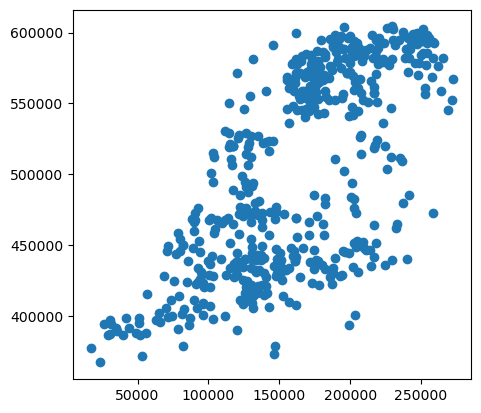

In [ ]:
geocoded_complete_gdf.plot()


In [129]:
geocoded_complete_gdf.to_file("output.gpkg", driver="GPKG")

<Axes: >

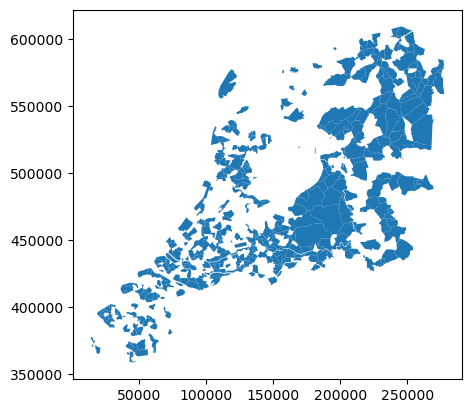

In [103]:
gem_1853_petitie_true.plot()


In [98]:
gem_1852_met_pet = gem_1853_provincie.merge(
    pet_1853,
    left_on=["gemeente", "provincie"],
    right_on=["Woonplaats", "Provincie"],
    how="left"
)

In [101]:
gem_1852_met_pet.head()

,gemeente,cbscode,geometry,provincie,Woonplaats,aantal name,Provincie,id
0,Sint Anna Termuiden,1177,"POLYGON ((15040.004 370729.999, 14490.004 369979.999, 13240.004 371519.999, 14950.004 373399.999, 15620.004 372619.999, 14990.004 371789.999, 15040.004 370729.999))",Zeeland,NaN,NaN,NaN,NaN
1,Heille,1073,"POLYGON ((17450.004 370869.999, 17620.004 370489.999, 17500.004 370239.999, 17790.004 368709.999, 18660.004 367449.999, 17920.004 366909.999, 18160.004 366379.999, 17670.004 365579.999, 17170.004 365579.999, 17070.004 365399.999, 16780.004 364889.999, 16470.004 364939.999, 16170.004 365509.999, 15540.004 365879.999, 15160.004 366859.999, 14610.004 366869.999, 14330.004 367179.999, 14410.004 367569.999, 14710.004 367639.999, 14720.004 368299.999, 14070.004 368819.999, 13790.004 369289.999, 13820.004 369789.999, 14490.004 369979.999, 15040.004 370729.999, 15850.004 370609.999, 16320.004 371229.999, 17100.004 371279.999, 17000.004 371009.999, 17450.004 370869.999))",Zeeland,NaN,NaN,NaN,NaN
2,Sluis,713,"POLYGON ((16320.004 371229.999, 15850.004 370609.999, 15040.004 370729.999, 14990.004 371789.999, 15620.004 372619.999, 15700.004 371969.999, 16320.004 371229.999))",Zeeland,Sluis,119.0,Zeeland,868.0
3,Eede,1052,"POLYGON ((18930.004 366129.999, 18920.004 365399.999, 19530.004 365459.999, 20420.004 365379.999, 20710.004 366119.999, 21680.004 365599.999, 21770.004 364919.999, 24780.005 363749.999, 24830.005 363519.999, 19100.004 363049.999, 18220.004 363619.999, 17750.004 363469.999, 17580.004 364639.999, 17070.004 365399.999, 17170.004 365579.999, 17670.004 365579.999, 18160.004 366379.999, 18500.004 366149.999, 18930.004 366129.999))",Zeeland,NaN,NaN,NaN,NaN
4,Sint Kruis,1178,"POLYGON ((25090.005 369759.999, 25070.005 369319.999, 26550.005 368879.999, 26860.005 368559.999, 26120.005 368479.999, 25880.005 367889.999, 25420.005 367579.999, 25050.005 368159.999, 24090.005 367959.999, 24780.005 363749.999, 21770.004 364919.999, 21680.004 365599.999, 20710.004 366119.999, 20700.004 366539.999, 21060.004 366559.999, 21000.004 368629.999, 21560.004 369499.999, 22280.004 369369.999, 22330.004 369799.999, 22840.004 369839.999, 22890.004 370499.999, 23640.004 370629.999, 24290.004 369769.999, 25090.005 369759.999))",Zeeland,NaN,NaN,NaN,NaN


In [110]:
points_with_poly = gpd.sjoin(
    geocoded_complete_gdf,
    gem_1852_met_pet,
    how="left",          
    predicate="within"   
)

<Axes: >

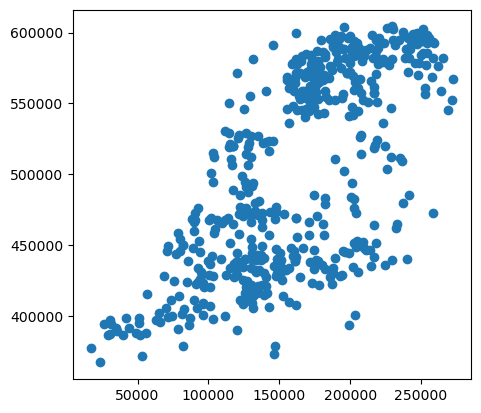

In [111]:
points_with_poly.plot()

In [115]:
points_with_poly.head(10)

,Woonplaats_left,Provincie_left,aantal name_left,id_left,lat,lon,geometry,index_right,gemeente,cbscode,provincie,Woonplaats_right,aantal name_right,Provincie_right,id_right
0,"Andel, den",Groningen,66,3,53.403824,6.518971,POINT (230272.493 602537.882),1177.0,Baflo,4.0,Groningen,NaN,NaN,NaN,NaN
1,"Apel, Ter",Groningen,36,4,52.882894,7.078466,POINT (268840.535 545306.353),1201.0,Vlagtwedde,48.0,Groningen,NaN,NaN,NaN,NaN
2,"Boer, Ten",Groningen,52,10,53.273014,6.694938,POINT (242239.586 588179.549),1191.0,Ten Boer,9.0,Groningen,NaN,NaN,NaN,NaN
3,Eenum,Groningen,21,13,53.336641,6.783525,POINT (248011.444 595370.887),1196.0,'t Zandt,54.0,Groningen,NaN,NaN,NaN,NaN
4,Enumatil,Groningen,50,15,53.21458,6.410933,POINT (223386.883 581370.116),1157.0,Leek,22.0,Groningen,Leek,53.0,Groningen,30.0
5,Garrelsweer,Groningen,9,18,53.305256,6.770773,POINT (247229.248 591862.000),1193.0,Loppersum,24.0,Groningen,Loppersum,58.0,Groningen,36.0
6,Garsthuizen,Groningen,28,19,53.37213,6.730324,POINT (244394.182 599252.705),1192.0,Stedum,41.0,Groningen,Stedum,117.0,Groningen,71.0
7,Grootegast en Oldekerk,Groningen,31,21,53.229144,6.33167,POINT (218070.985 582918.507),1160.0,Oldekerk,36.0,Groningen,NaN,NaN,NaN,NaN
8,Harkstede en Scharner,Groningen,9,24,53.21962,6.681073,POINT (241421.484 582221.291),1184.0,Slochteren,40.0,Groningen,Slochteren,7.0,Groningen,68.0
9,Houwerzijl en Zoutkamp,Groningen,135,25,53.333176,6.338418,POINT (218368.596 594501.686),1134.0,Ulrum,45.0,Groningen,Ulrum,122.0,Groningen,79.0


In [135]:
# blijkt dat niet alle punten in een polygoon liggen...

geocode_wrong = points_with_poly[points_with_poly["cbscode"].isna()]
geocode_right = points_with_poly[points_with_poly["cbscode"].notna()]

<Axes: >

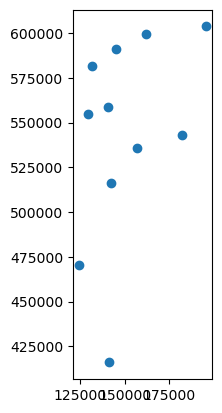

In [133]:
geocode_wrong.plot()

In [ ]:
# in QGIS manueel de punten aangepast..
geocode_wrong.to_file("geocode_wrong.gpkg", driver="GPKG")


In [142]:
geocode_wrong_corrected = gpd.read_file("geocode_wrong.gpkg")

In [143]:
geocoded_complete_corrected = pd.concat([geocode_wrong_corrected, geocode_right], ignore_index=True)


In [160]:
geocoded_complete_corrected.head(10)

,Woonplaats_left,Provincie_left,aantal name_left,id_left,lat,lon,index_right,gemeente,cbscode,provincie,Woonplaats_right,aantal name_right,Provincie_right,id_right,geometry
0,Wierum en Dorkwerd,Groningen,116,90,53.41848519,5.99444067,None,Westdongeradeel,97.0,None,None,None,None,None,POINT (196728.091 601031.609)
1,Hemelum&Mirns&Bakhuizen,Friesland,60,151,52.81102901,5.4173818,None,Hemelumer Oldephaerd en Noordwolde,1260.0,None,None,None,None,None,POINT (159753.786 543682.606)
2,Oosterend,Friesland,105,190,53.38144964,5.49308401,None,Terschelling,93.0,None,None,None,None,None,POINT (158455.120 602639.073)
3,Vinkeveen,Utrecht,48,505,52.22073148,4.94283895,None,Vinkeveen en Waverveen,346.0,None,None,None,None,None,POINT (123947.530 469800.552)
4,Oosterland en Stroeve en Den Oever,Noord-Holland,113,586,52.98108924,5.00540487,None,Wieringen,462.0,None,None,None,None,None,POINT (130810.185 549506.227)
5,Vlieland,Noord-Holland,239,615,53.21969428,5.03464993,None,Vlieland,96.0,None,None,None,None,None,POINT (126317.871 584499.367)
6,West-Terschelling,Noord-Holland,125,620,53.30458499,5.24124525,None,Terschelling,93.0,None,None,None,None,None,POINT (142426.270 597054.564)
7,Wijdenes en Oosterleek,Noord-Holland,9,629,52.63587454,5.20044462,None,Wijdenes,469.0,None,None,None,None,None,POINT (139480.604 516374.155)
8,Vlijmen&Hedikhuizen,Noord Brabant en Limburg,60,925,51.73260804,5.18833853,None,Hedikhuizen,1071.0,None,None,None,None,None,POINT (140604.452 415393.902)
9,Oosterzee&Echten,Friesland,251,196,52.87375,5.785,None,Lemsterland,82.0,None,None,None,None,None,POINT (181316.728 542821.883)


In [145]:
controle_lijst_geocode = geocoded_complete_corrected[['Woonplaats_left','Provincie_left', 'aantal name_left', 'id_left', 'gemeente', 'cbscode']].rename(columns={
    "Woonplaats_left": "Woonplaats",
    "Provincie_left": "Provincie",
    "aantal name_left": "aantal",
    "id_left": "id"
})

In [146]:
controle_lijst_string_match = gem_1853_petitie_true[['Woonplaats','Provincie', 'aantal name', 'id', 'gemeente', 'cbscode']].rename(columns={
    "aantal name": "aantal"    
})

In [147]:
controle_lijst = pd.concat([ controle_lijst_geocode , controle_lijst_string_match], ignore_index=True)

In [148]:
controle_lijst.to_excel("controlelijst.xlsx")

In [151]:
controle_lijst.head()

,Woonplaats,Provincie,aantal,id,gemeente,cbscode
0,Wierum en Dorkwerd,Groningen,116,90,Westdongeradeel,97
1,Hemelum&Mirns&Bakhuizen,Friesland,60,151,Hemelumer Oldephaerd en Noordwolde,1260
2,Oosterend,Friesland,105,190,Terschelling,93
3,Vinkeveen,Utrecht,48,505,Vinkeveen en Waverveen,346
4,Oosterland en Stroeve en Den Oever,Noord-Holland,113,586,Wieringen,462


In [150]:
controle_lijst["cbscode"] = controle_lijst["cbscode"].astype(int)

In [152]:

totaal_per_cbs_code = controle_lijst.groupby("cbscode", as_index=False)["aantal"].sum()

In [156]:
totaal_per_cbs_code.shape

(662, 2)

<Axes: >

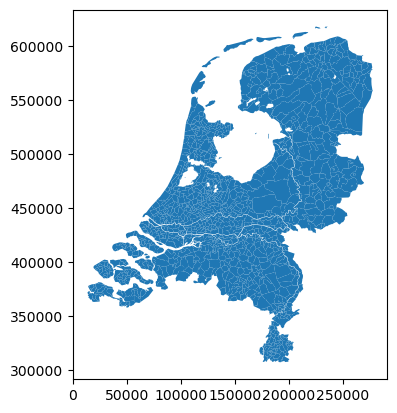

In [155]:
gem_1853.plot()

In [158]:
petitie_linked_gem_1853 = gem_1853.merge(totaal_per_cbs_code, on="cbscode", how="left")

In [159]:
petitie_linked_gem_1853.to_file("petitie_linked_gem_1853.gpkg", driver="GPKG")